In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 24.2 s, sys: 2.63 s, total: 26.8 s
Wall time: 28.6 s


(17937758, 9)

While attempting to train the model, it turned out that the reading and unpickling operation done at this scale, with so many files, is very computationally expensive.

But the examples in the mfcc represenatations are very small. Let's read them all into the memory before training.

In [3]:
# uniq_fns = np.unique(df.target_fn.values)

In [4]:
# %%time

# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [5]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 17.3 s, sys: 14.2 s, total: 31.4 s
Wall time: 2min 28s


In [6]:
vocab = list(df.source_word.unique())

In [7]:
# from collections import Counter
# counter = Counter(df.source_word)

# most_common_words = set([t[0] for t in counter.most_common(1000)])

I suspect that reading the data from a file saved within numpy (`numpy.save`) is much less computationally expensive than unpickling it, but I might be wrong. Either way, at ~4 million of unique utterances, the dataset is small enough to comfortably fit within memory of a GCP instance (at ~53GBs used RAM during training).

This might not be ideal for experimentation on home rigs. Saving the data using `numpy.save` and evaluating performance would definitely be a very interesting and useful exercise.

In [8]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,8af4aebcf4a74004b02db9f88d99e89a,1cb9442ec1a6468282da309756e2ff57,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,8af4aebcf4a74004b02db9f88d99e89a,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,1cb9442ec1a6468282da309756e2ff57,8af4aebcf4a74004b02db9f88d99e89a,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,1cb9442ec1a6468282da309756e2ff57,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,1cb9442ec1a6468282da309756e2ff57,155ad336d88c4cbf814a1237983b5b18,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [9]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [10]:
train_examples.size, valid_examples.size

(159688530, 1751292)

In [11]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for i, features in enumerate(fn2features.values()):
    lengths.append(features.shape[0])

CPU times: user 4.9 s, sys: 144 ms, total: 5.05 s
Wall time: 5.05 s


In [12]:
max(lengths)

291

In [13]:
np.mean(lengths)

29.028019713968394

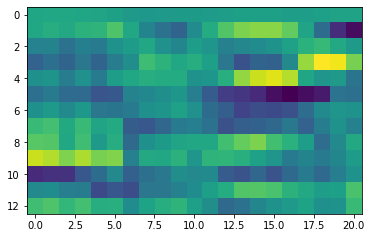

In [14]:
plt.imshow(features.T)

In [15]:
dataset_mean = -5
dataset_std = 15

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [16]:
%%time

word2row_idxs = defaultdict(lambda: list())

for idx, row in df.iterrows():
    word2row_idxs[row.source_word].append(idx)

CPU times: user 22min 12s, sys: 1.97 s, total: 22min 14s
Wall time: 22min 14s


In [17]:
def prepare_features(word, fns, pad_to=max(lengths), pad_left=False):
    row_idx = np.random.randint(len(word2row_idxs[word]))
    ary = fn2features[fns[row_idx]]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [18]:
dss = Datasets(
    vocab * 5,
    [lambda word: normalize_data(prepare_features(word, df.source_fn, pad_left=True)),
     lambda word: normalize_data(prepare_features(word, df.target_fn)),
     lambda word: normalize_data(prepare_features(word, df.target_fn))],
    n_inp=2,
    splits = [np.arange(len(vocab)*4), np.arange(len(vocab)*4, len(vocab)*5)]
)

In [19]:
BS = 32
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(dss.train, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(dss.valid, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [20]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [21]:
# # unidirectional encoder
# teacher_forcing_ratio = 0

# class Model(Module):
#     def __init__(self, hidden_size=50):
#         self.encoder= nn.LSTM(
#             input_size=13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.decoder = nn.LSTM(
#             input_size=hidden_size+13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.lin = nn.Linear(hidden_size, 13)
            
#     def forward(self, source_features, target_features):
#         _, (embeddings_dec, _) = self.encoder(source_features)
        
#         outputs = torch.zeros_like(target_features)
#         input = target_features[:, 4:5, :]
#         outputs[:, :4, :] = target_features[:, :4, :]
        
#         hidden = embeddings_dec
#         embeddings_dec = embeddings_dec.squeeze(0)
        
#         cell = torch.zeros_like(embeddings_dec).unsqueeze(0)
#         for t in range(1, target_features.shape[1]):
#             input = torch.cat((input, embeddings_dec.unsqueeze(1)), 2)
#             x, (hidden, cell) = self.decoder(input, (hidden, cell))
#             x = self.lin(x)
#             input = (torch.sigmoid(x) - 0.5) * 16
#             outputs[:, t, :] = input.squeeze()
            
#             if random.random() < teacher_forcing_ratio:
#                 input = target_features[:, t, :].unsqueeze(1)
#         return outputs

In [22]:
# teacher_forcing_ratio = 0

# class Model(Module):
#     def __init__(self, hidden_size=50):
#         self.encoder= nn.LSTM(
#             input_size=13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.decoder = nn.LSTM(
#             input_size=hidden_size+13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.lin = nn.Linear(hidden_size, 13)
            
#     def forward(self, source_features, target_features):
#         _, (embeddings, _) = self.encoder(source_features)
#         input = torch.cat(
#             (
#                 target_features[:, :-1, :],
#                 embeddings.permute(1, 0, 2).repeat(1, target_features.shape[1]-1, 1)
#             ), 2)
#         cell = torch.zeros_like(embeddings)
#         x, _ = self.decoder(input, (embeddings, cell))
#         return self.lin(x)

In [23]:
# unidirectional encoder
teacher_forcing_ratio = 0

class Model(Module):
    def __init__(self, hidden_size=50):
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size+13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin = nn.Linear(hidden_size, 13)
            
    def forward(self, source_features, target_features):
        _, (embeddings_dec, _) = self.encoder(source_features)
        
        outputs = torch.zeros_like(target_features)
        input = target_features[:, :1, :]
        outputs[:, 0, :] = input.squeeze()
        
        hidden = embeddings_dec
        embeddings_dec = embeddings_dec.squeeze(0)
        
        cell = torch.zeros_like(embeddings_dec).unsqueeze(0)
        for t in range(1, target_features.shape[1]):
            input = torch.cat((input, embeddings_dec.unsqueeze(1)), 2)
            x, (hidden, cell) = self.decoder(input, (hidden, cell))
            x = self.lin(x)
            input = (torch.sigmoid(x) - 0.5) * 16
            outputs[:, t, :] = input.squeeze()
            
            if random.random() < teacher_forcing_ratio:
                input = target_features[:, t, :].unsqueeze(1)
        return outputs

In [24]:
## bidirectional encoder
#
# teacher_forcing_ratio = 0

# class Model(Module):
#     def __init__(self, hidden_size=50):
#         self.encoder= nn.LSTM(
#             input_size=13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=True
#         )
#         self.decoder = nn.LSTM(
#             input_size=2*hidden_size+13,
#             hidden_size=2*hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.lin = nn.Linear(2*hidden_size, 13)
            
#     def forward(self, source_features, target_features):
#         _, (embeddings_dec, _) = self.encoder(source_features)
#         embeddings_dec = embeddings_dec.view(embeddings_dec.shape[1], -1)
        
#         outputs = torch.zeros_like(target_features)
#         input = target_features[:, :1, :]
#         outputs[:, 0, :] = input.squeeze()
    
#         hidden = embeddings_dec.unsqueeze(0)
#         cell = torch.zeros_like(embeddings_dec).unsqueeze(0)
#         for t in range(1, target_features.shape[1]):
#             input = torch.cat((input, embeddings_dec.unsqueeze(1)), 2)
#             x, (hidden, cell) = self.decoder(input, (hidden, cell))
#             x = self.lin(x)
#             input = (torch.sigmoid(x) - 0.5) * 16
#             outputs[:, t, :] = input.squeeze()
            
#             if random.random() < teacher_forcing_ratio:
#                 input = target_features[:, t, :].unsqueeze(1)
#         return outputs

In [25]:
# mse_loss = MSELoss()
# def modified_MSE(preds, targs):
#     mask = targs == 0
#     preds[mask] = 0
#     return mse_loss(preds, targs)

mse_loss = MSELoss()
def targ_trunc_MSE(preds, targs):
    return mse_loss(preds, targs[:, 1:, :])

learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3, opt_func=SGD)

In [ ]:
learn.fit(40, cbs=SaveModelCallback(fname='1e-3_SGD', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.078469,0.079252,54:16
1,0.078155,0.078031,54:31
2,0.076025,0.077604,56:15
3,0.075850,0.076503,59:31
4,0.074447,0.074504,55:45
5,0.069219,0.068355,55:18
6,0.065502,0.063539,55:43
7,0.061216,0.061305,57:30
8,0.059896,0.061053,58:45
9,0.061091,0.060678,58:50


## Calculate embedding for each unique word in the dataset

In [ ]:
df_unique_utterances = df.drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [ ]:
dss_all_utterances = Datasets(
    df_unique_utterances,
    [lambda row: normalize_data(prepare_features(row.source_fn, pad_left=True)),
     lambda row: normalize_data(prepare_features(row.target_fn))],
    n_inp=2
)

In [ ]:
all_dl = DataLoader(dss_all_utterances, BS, NUM_WORKERS)

In [ ]:
%%time

all_embeddings = []
with torch.no_grad():
    learn.model.train = False
    for batch in all_dl:
        _, (embeddings, _) = learn.model.encoder(batch[0].cuda())
        all_embeddings.append(embeddings.view(embeddings.shape[1], -1).detach().cpu())

In [ ]:
all_embeddings = torch.cat(all_embeddings)

In [ ]:
with torch.no_grad():
    for batch in all_dl:
        outputs = learn.model(batch[0].cuda(), batch[1].cuda())
        break

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-1].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-1].cpu().numpy().T[:, :20])

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-10].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-10].cpu().numpy().T[:, :20])

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[0].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][0].cpu().numpy().T[:, :20])

In [ ]:
%%time

word2row_idxs = defaultdict(lambda: list())

for idx, row in df_unique_utterances.iterrows():
    word2row_idxs[row.source_word].append(idx)
    
word2embedding = {}

for k, v in word2row_idxs.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [ ]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [ ]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [ ]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [ ]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

In [ ]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))